In [2]:
# Rig C with lightcrafter in video mode.

import h5py
from parse_data import Symphony2Reader
import matplotlib.pyplot as plt
import numpy as np



In [ ]:


h5_path='/Users/michaelmanookin/Documents/Data/rawdata/MEA_Data/data/h5/20240523C.h5'
out_path = '/Users/michaelmanookin/Documents/Data/rawdata/MEA_Data/data/h5/20240523C.json'
stage_type='Lightcrafter'
self = Symphony2Reader(h5_path=h5_path, out_path=out_path, stage_type=stage_type)
self.file = h5py.File(self.h5_path, 'r')

keys = list(self.file.keys())
self.file['experiment-4c9de5ef-939a-4d41-a8c8-6e972afe3b55/epochGroups'].keys()
self.file['experiment-4c9de5ef-939a-4d41-a8c8-6e972afe3b55/epochGroups/epochGroup-f2f893d6-61b4-4c55-8c56-e4ef52ceab1b'].attrs['label']
responses = self.file['experiment-4c9de5ef-939a-4d41-a8c8-6e972afe3b55/epochGroups/epochGroup-f2f893d6-61b4-4c55-8c56-e4ef52ceab1b/epochBlocks/manookinlab.protocols.SpatialNoise-8bb5a31f-3949-44aa-ae16-07cc2703a24e/epochs/epoch-0b0b3aa2-d033-4b7c-9492-c4b1959ee954/responses']
frame_monitor = responses['Frame Monitor-38e8df0b-2b2d-4f38-b88f-3b6c671f270c']['data']['quantity']
red_sync = responses['Red Sync-5d1f719a-94f4-4eb9-ba52-2cfa4c1857d1']['data']['quantity']

# Pull the metadata.
self.metadata = self.read_file()

# Experiment level: self.metadata['sources'][0]
# Preparation level: self.metadata['sources'][0]['sources'][0]['label']
# Number of mounts: len(self.metadata['sources'][0]['sources'])
# self.metadata['group'][0]['source']['label'] gives the cell source.

In [80]:
import h5py
from parse_data import Symphony2Reader

h5_path='/Users/michaelmanookin/Documents/Data/datajoint/mea/20250121C.h5'
out_path = '/Users/michaelmanookin/Documents/Data/rawdata/MEA_Data/data/h5/20240523C.json'
stage_type='Lightcrafter'
self = Symphony2Reader(h5_path=h5_path, out_path=out_path, stage_type=stage_type)
self.file = h5py.File(self.h5_path, 'r')
keys = list(self.file.keys())
group_keys = list(self.file['experiment-22f5a694-32e4-4fb8-a0e1-85ecdbcdf6d9/epochGroups'].keys())
frame_monitor = self.file['experiment-22f5a694-32e4-4fb8-a0e1-85ecdbcdf6d9/epochGroups/' + group_keys[2] + '/epochBlocks/manookinlab.protocols.SpatialNoise-25037b7f-3057-4fdd-8cf9-0596d5325cd2/epochs/epoch-0a6faf0f-3f0a-43c8-9f36-18583cde8c3d/responses/Frame Monitor-8199e3c2-2541-44e1-add7-3fc1e1fd2c16']['data']['quantity']


from parse_data import get_frame_times_lightcrafter, find_optimal_threshold_video, lcr_frame_times_video
frame_times = get_frame_times_lightcrafter(frame_monitor,bin_rate=1000.0,sample_rate=1000.0)

threshold = find_optimal_threshold_video(f_monitor = frame_monitor,sample_rate=1000.0,low_pass_filter=True)
f_monitor = frame_monitor.copy()
f_monitor = f_monitor - np.min(f_monitor)
f_monitor /= np.max(f_monitor)

print(frame_times.shape)

(10818,)


In [97]:
from parse_data import find_threshold_cross, bessel_lowpass_filter

def get_frame_times_from_walk(f_monitor: np.ndarray, 
    threshold: float=0.2,
    expected_frame_rate: float=59.94169871759346, 
    sample_rate: float=10000.0,
    low_pass_filter: bool=True):
    expected_down_step = (sample_rate / expected_frame_rate)*2.0
    num_expected_down_steps = np.floor(float(len(f_monitor))/expected_down_step).astype(int)
    if low_pass_filter:
        f_cutoff = sample_rate/10.0*3.0
        f_monitor = bessel_lowpass_filter(f_monitor,f_cutoff,sample_rate)
        f_monitor /= np.max(f_monitor)
    frame_ups = find_threshold_cross(f_monitor,threshold=threshold,direction=1)
    frame_downs = find_threshold_cross(f_monitor,threshold=threshold,direction=-1)
    frame_transitions = []
    frame_downs = np.array(frame_downs)
    window_floor = 5.0/1000.0*sample_rate
    window_ceil = 10.0/1000.0*sample_rate
    for ii in range(num_expected_down_steps):
        search_center = np.round(ii*expected_down_step + expected_down_step/2.0)
        target_downs = np.argwhere((frame_downs > search_center-window_floor) & (frame_downs < search_center+window_ceil))[0]
        if target_downs.size > 0:
            good_down = frame_downs[target_downs.ravel()[-1]]
            frame_transitions.append(good_down)
            # Find the next frame up to occur after the good down.
            next_ups = frame_ups[frame_ups > good_down]
            if next_ups.size > 0:
                good_up = next_ups[0]
                frame_transitions.append(good_up)
        else:
            # If no valid downs, just take the first one.
            print('No valid downs found.')
    # if frame_transitions[0] >= (13.0/sample_rate*1000.0):
    #     frame_transitions.append(0.0)
    frame_transitions = np.array(frame_transitions).astype(float)
    return np.sort(frame_transitions)


# Input variables
expected_frame_rate=59.94169871759346
sample_rate=1000.0
low_pass_filter=True
threshold = 0.2
jitter_tolerance = 2.0
min_frame_interval = np.floor((sample_rate / expected_frame_rate) - (jitter_tolerance/1000.0*sample_rate))
min_frame_interval = min_frame_interval.astype(int)

if low_pass_filter:
    f_cutoff = sample_rate/10.0*3.0
    f_monitor = bessel_lowpass_filter(f_monitor,f_cutoff,sample_rate)
    f_monitor /= np.max(f_monitor)
frame_ups = find_threshold_cross(f_monitor,threshold=threshold,direction=1)
frame_downs = find_threshold_cross(f_monitor,threshold=threshold,direction=-1)

frame_transitions = get_frame_times_from_walk(f_monitor,threshold=threshold,expected_frame_rate=expected_frame_rate,sample_rate=sample_rate,low_pass_filter=low_pass_filter)
print(frame_transitions.shape)

(10817,)


In [ ]:
print(frame_ups.shape)
print(frame_downs.shape)
print(min_frame_interval)
print(len(f_monitor))

expected_down_step = (sample_rate / expected_frame_rate)*2.0
num_expected_down_steps = np.floor(float(len(f_monitor))/expected_down_step).astype(int)

# See if any frame downs occur within the search range.
frame_transitions = []
frame_downs = np.array(frame_downs)
window_floor = 5.0/1000.0*sample_rate
window_ceil = 10.0/1000.0*sample_rate

for ii in range(num_expected_down_steps):
    search_center = np.round(ii*expected_down_step + expected_down_step/2.0)
    target_downs = np.argwhere((frame_downs > search_center-window_floor) & (frame_downs < search_center+window_ceil))[0]
    if target_downs.size > 0:
        good_down = frame_downs[target_downs.ravel()[-1]]
        frame_transitions.append(good_down)
        # Find the next frame up to occur after the good down.
        next_ups = frame_ups[frame_ups > good_down]
        if next_ups.size > 0:
            good_up = next_ups[0]
            frame_transitions.append(good_up)
    else:
        # If no valid downs, just take the first one.
        print('No valid downs found.')

frame_transitions = np.array(frame_transitions).astype(float)
print(frame_transitions.shape)
print(np.min(np.diff(frame_transitions)))
print(np.max(np.diff(frame_transitions)))

(5408,)
(5409,)
14
180500
(10817,)
14
19


Max frame time: 180458
Min frame time: 0
Frame time shape: (10818,)
16
180458
(180500,)
180442
Expected down transitions: 5407.0
Actual down transitions: 5408
33.365754437869825
33.37809840917499
59.94169871759346
59.930614823599825


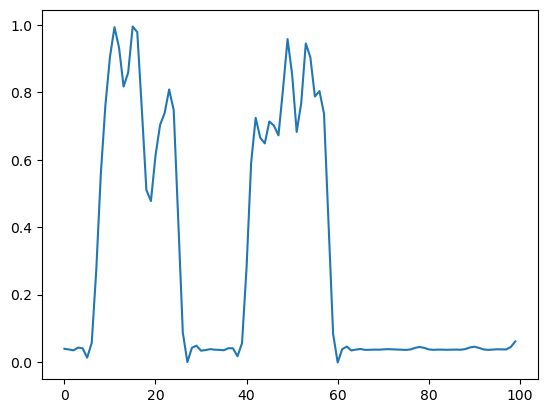

In [55]:
from parse_data import find_threshold_cross, bessel_lowpass_filter

def check_frame_up_down(f_up_down, expected_frame_rate: float=59.94):
    pass

low_pass_filter = True
sample_rate = 1000.0

# threshold = find_optimal_threshold_video(f_monitor = frame_monitor,sample_rate=1000.0,low_pass_filter=True)
threshold = 0.2
f_monitor = frame_monitor.copy()
f_monitor = f_monitor - np.min(f_monitor)
f_monitor /= np.max(f_monitor)

minimum_samples = np.round(13.0*sample_rate/1000.0).astype(int)
f_monitor -= np.min(f_monitor)
f_monitor /= np.max(f_monitor)
if low_pass_filter:
    f_cutoff = sample_rate/10.0*3.0
    f_monitor = bessel_lowpass_filter(f_monitor,f_cutoff,sample_rate)
    f_monitor /= np.max(f_monitor)
frame_ups = find_threshold_cross(f_monitor,threshold=threshold,direction=1)
frame_downs = find_threshold_cross(f_monitor,threshold=threshold,direction=-1)
# Combine the frame up and down times.
flips = np.concatenate((frame_ups,frame_downs))
flips = np.sort(flips)
d_flip = np.diff(flips)
# Find the down-up transitions.
frame_down_up = np.where(d_flip >= minimum_samples)[0] # This is jacked up!!
# Get the frame times.
# frame_times = np.concatenate((flips[frame_down_up],flips[frame_down_up+1],np.array([0]))) # This doesn't work!!!
frame_times = np.concatenate((flips, np.array([0])))
frame_times = np.sort(frame_times)

print('Max frame time:',np.max(frame_times))
print('Min frame time:',np.min(frame_times))
print('Frame time shape:',frame_times.shape)

print(frame_downs[0])
print(frame_downs[-1])
print(f_monitor.shape)

down_max_min = frame_downs[-1]-frame_downs[0]
print(down_max_min)
# expected_downs = np.floor(180480 / 1000 * 59.94 / 2)
expected_downs = np.floor(down_max_min / 1000 * 59.94 / 2)
print('Expected down transitions:', expected_downs)
print('Actual down transitions:', frame_downs.shape[0]-1)

# 180442/5409
interval = 180442 / 5408
print(interval)
print(down_max_min/(expected_downs-1))

print(1000.0/interval*2)
print(1000.0/(down_max_min/expected_downs)*2)


plt.plot(f_monitor[-100:])

In [79]:
sample_rate = 1000.0
expected_frame_rate = 59.94169871759346
jitter_tolerance = 2.0
# frame_up_down = frame_downs.copy()
# Compute the minimum and maximum interval for frames without drops.
min_frame_interval = np.floor((sample_rate / expected_frame_rate) - (jitter_tolerance/1000.0*sample_rate))
max_frame_interval = np.ceil((sample_rate / expected_frame_rate) + (jitter_tolerance/1000.0*sample_rate))
min_frame_interval = min_frame_interval.astype(int)
max_frame_interval = max_frame_interval.astype(int)
print('Min frame interval:', min_frame_interval)
print('Max frame interval:', max_frame_interval)

threshold = 0.2
# f_monitor = frame_monitor.copy()
# f_monitor = f_monitor - np.min(f_monitor)
# f_monitor /= np.max(f_monitor)

# minimum_samples = np.round(13.0*sample_rate/1000.0).astype(int)
# f_monitor -= np.min(f_monitor)
# f_monitor /= np.max(f_monitor)
# if low_pass_filter:
#     f_cutoff = sample_rate/10.0*3.0
#     f_monitor = bessel_lowpass_filter(f_monitor,f_cutoff,sample_rate)
#     f_monitor /= np.max(f_monitor)

# Loop through the frame monitor and find the up and down transitions.
frame_downs = find_threshold_cross(f_monitor,threshold=threshold,direction=-1)

# Start at the first negative transition.
# frame_transitions = []
# frame_transitions.append(frame_downs[0])
# last_transition = int(frame_downs[0])
# last_transition_polarity = -1
# # Loop through the frame monitor and find the up and down transitions.
# for ii in range(int(frame_downs[0])+1, f_monitor.shape[0]):
#     if last_transition_polarity == -1:
#         # If the last transition was negative, check for a positive transition.
#         if (f_monitor[ii] > threshold) and (f_monitor[ii-1] <= threshold):
#             # Check if the interval is within the expected range.
#             if (ii - last_transition) >= min_frame_interval:
#                 # If the interval is within the expected range, add the transition.
#                 frame_transitions.append(ii)
#                 last_transition = ii
#                 last_transition_polarity = 1
#     elif last_transition_polarity == 1:
#         # If the last transition was positive, check for a negative transition.
#         if (f_monitor[ii] < threshold) and (f_monitor[ii-1] >= threshold):
#             # Check if the interval is within the expected range.
#             if (ii - last_transition) >= min_frame_interval:
#                 frame_transitions.append(ii)
#                 last_transition = ii
#                 last_transition_polarity = -1

frame_transitions = []
frame_transitions.append(frame_downs[0])
last_transition = int(frame_downs[0])
# Loop through the frame monitor and find the up and down transitions.
for ii in range(int(frame_downs[0])+1, f_monitor.shape[0]):
    if ((f_monitor[ii] >= threshold) and (f_monitor[ii-1] < threshold)) or ((f_monitor[ii] <= threshold) and (f_monitor[ii-1] > threshold)):
        if (ii - last_transition) >= min_frame_interval:
            # If the interval is within the expected range, add the transition.
            frame_transitions.append(ii)
            last_transition = ii

frame_transitions = np.array(frame_transitions)
print(frame_transitions.shape)
print(frame_transitions[:10])
print(1000/((frame_transitions[-1]-frame_transitions[0])/(frame_transitions.shape[0]-1)))
# if direction > 0:
#         index = np.argwhere((x_original < threshold) & (x_shift >= threshold)).ravel()
#     else:
#         index = np.argwhere((x_original >= threshold) & (x_shift < threshold)).ravel()

Min frame interval: 14
Max frame interval: 19
(10817,)
[ 16  32  51  65  84  99 117 132 151 166]
59.941366525717264


In [75]:
print(ii)

180499


In [70]:
def check_frame_up_down(
    frame_up_down: np.ndarray, 
    expected_frame_rate: float=59.94169871759346, 
    sample_rate: float=10000.0,
    jitter_tolerance: float=2.0):
    """ Compute the frame up and down intervals.
    Parameters:
        frame_up_down: The frame up and down times.
        expected_frame_rate: The expected frame rate.
        sample_rate: The sample rate of the data.
    Returns:
      out_intervals: The output intervals.
    """
    # Compute the minimum and maximum interval for frames without drops.
    min_frame_interval = np.floor((sample_rate / expected_frame_rate * 2) - (jitter_tolerance/1000.0*sample_rate))
    # max_frame_interval = np.ceil((sample_rate / expected_frame_rate * 2) + (jitter_tolerance/1000.0*sample_rate))
    frame_diff = np.diff(frame_up_down)
    if (np.min(frame_diff) >= min_frame_interval): #if (np.min(frame_diff) >= min_frame_interval) and (np.max(frame_diff) <= max_frame_interval):
        return frame_up_down
    else:
        # Remove frames that are not within the tolerance.
        try:
            ii = 0
            while ii < len(frame_up_down)-1:
                frame_diff = np.diff(frame_up_down[ii:ii+2])
                if (np.min(frame_diff) >= min_frame_interval):
                    ii += 1
                else:
                    # Remove the next frame up down time.
                    frame_up_down = np.delete(frame_up_down, ii+1)
        except:
            pass
        return frame_up_down

sample_rate = 1000.0
expected_frame_rate = 59.94169871759346
jitter_tolerance = 2.0
# frame_up_down = frame_downs.copy()
# Compute the minimum and maximum interval for frames without drops.
min_frame_interval = np.floor((sample_rate / expected_frame_rate * 2) - (jitter_tolerance/1000.0*sample_rate))
max_frame_interval = np.ceil((sample_rate / expected_frame_rate * 2) + (jitter_tolerance/1000.0*sample_rate))
print('Min frame interval:', min_frame_interval)
print('Max frame interval:', max_frame_interval)

print(frame_downs[0])
print(frame_downs[-1])
print(frame_downs.shape)

frame_up_down = frame_downs.copy()

down_intervals = check_frame_up_down(frame_up_down=frame_ups, expected_frame_rate=expected_frame_rate, sample_rate=sample_rate, jitter_tolerance=jitter_tolerance)

print(np.min(down_intervals))
print(np.max(down_intervals))

fr = sample_rate / ((down_intervals[-1] - down_intervals[0])/(len(down_intervals)-1)) * 2.0
print('Frame rate:', fr)

Min frame interval: 31.0
Max frame interval: 36.0
16
180458
(5409,)
31
180439
Frame rate: 59.941909449691806


In [66]:
# print(frame_up_down[:10])

# # Insert an extra frame up down time to test...
# frame_up_down = np.concatenate((frame_up_down, np.array([63])))
# frame_up_down = np.sort(frame_up_down)
print(frame_up_down[:10])

ii = 0
while ii < len(frame_up_down)-1:
    frame_diff = np.diff(frame_up_down[ii:ii+2])
    if (np.min(frame_diff) >= min_frame_interval):
        ii += 1
    else:
        # Remove the next frame up down time.
        frame_up_down = np.delete(frame_up_down, ii+1)

print(frame_up_down[:10])


[ 16  50  63  83 116 150 183 215 250 283]
[ 16  50  83 116 150 183 215 250 283 316]


In [71]:

frame_ups = check_frame_up_down(frame_up_down=frame_ups, expected_frame_rate=59.94169871759346, sample_rate=sample_rate)
frame_downs = check_frame_up_down(frame_up_down=frame_downs, expected_frame_rate=59.94169871759346, sample_rate=sample_rate)

flips = np.concatenate((frame_ups,frame_downs))
# Get the frame times.
frame_times = np.concatenate((flips, np.array([0])))
frame_times = np.sort(frame_times)




In [ ]:
bin_rate = 1000.0

avg_flip_time = (frame_times[-1] - frame_times[0]) / (len(frame_times) - 1)
print(bin_rate/avg_flip_time)

def calculate_frame_rate(frame_times: np.ndarray, bin_rate: float=1000.0):
    """
    Calculate the frame rate from the frame times.
    :param frame_times: The frame times in milliseconds.
    :param bin_rate: The bin rate in Hz.
    :return: The frame rate in Hz.
    """
    # Calculate the time between frames
    avg_flip_time = (frame_times[-1] - frame_times[0]) / (len(frame_times) - 1) 
    # Calculate the frame rate
    frame_rate = bin_rate/avg_flip_time
    return frame_rate

print(frame_times.shape)

elapsed_time = frame_times[-1] - frame_times[1]
print('Elapsed time:', elapsed_time)
# Calculate the average frame time.
avg_frame_time = elapsed_time / (len(frame_times) - 2)
print('Average frame time:', avg_frame_time)
# Compute the frame rate.
frame_rate = bin_rate / avg_frame_time
print('Frame rate:', frame_rate)

print(frame_times[:10])
print(frame_times[-10:])



59.941925545002164
(10818,)
Elapsed time: 180442
Average frame time: 16.682877218934912
Frame rate: 59.94169871759346
[  0  16  31  50  64  83  98 116 131 150]
[180306 180323 180339 180358 180372 180391 180406 180425 180439 180458]


In [53]:
print(frame_ups.shape)
print(frame_downs.shape)

print(frame_ups[0])
print(frame_ups[-1])
print(frame_downs[0])
print(frame_downs[-1])

(5406,)
(5408,)
31.0
180439.0
16.0
180458.0


In [7]:
from scipy.io import loadmat
from parse_data import find_threshold_cross, bessel_lowpass_filter, calculate_up_down_offsets
import numpy as np

sample_rate = 10000.0

mdic = loadmat('/Users/michaelmanookin/Documents/Data/datajoint/frames.mat')
frame_monitor = mdic['frame_monitor']
frame_monitor = frame_monitor[0, :]


In [ ]:
def check_frame_times(frame_times: np.ndarray, expected_frame_rate: float=60.0, bin_rate: float=1000.0):
    # Compute the minimum and maximum intervals from the expected frame rate (msec).
    minimum_interval = np.floor(bin_rate/expected_frame_rate).astype(float)
    maximum_interval = np.ceil(bin_rate/expected_frame_rate).astype(float)
    drop_interval = np.ceil(bin_rate/expected_frame_rate*1.5).astype(float)
    # Take the derivative of the frame times.
    d_frames = np.diff(frame_times)
    long_idx = np.where((d_frames > maximum_interval) & (d_frames < drop_interval))[0]
    if np.any(long_idx):
        frame_times[long_idx+1] -= (d_frames[long_idx] - maximum_interval)
    d_frames = np.diff(frame_times)
    short_idx = np.where(d_frames < minimum_interval)[0]
    frame_times[short_idx+1] += (minimum_interval - d_frames[short_idx])
    return frame_times


def lcr_frame_times_video(f_monitor: np.ndarray, threshold: float=0.5, sample_rate: float=10000.0, low_pass_filter: bool=True):
    """ Extract the frame times from the frame monitor signal (Lightcrafter 4500).
    Parameters:
        f_monitor: The frame monitor signal (np.ndarray).
        threshold: The threshold for detecting frame transitions (float).
        sample_rate: The sample rate in Hz (float).
        low_pass_filter: Apply a low-pass filter to the frame monitor signal (bool).
    Returns:
        frame_times: The frame times (np.ndarray)
    """
    minimum_samples = np.round(13.0*sample_rate/1000.0).astype(int)
    f_monitor -= np.min(f_monitor)
    f_monitor /= np.max(f_monitor)
    if low_pass_filter:
        f_cutoff = sample_rate/10.0*3.0
        f_monitor = bessel_lowpass_filter(f_monitor,f_cutoff,sample_rate)
        f_monitor /= np.max(f_monitor)
    frame_ups = find_threshold_cross(f_monitor,threshold=threshold,direction=1)
    frame_downs = find_threshold_cross(f_monitor,threshold=threshold,direction=-1)
    # Combine the frame up and down times.
    flips = np.concatenate((frame_ups,frame_downs))
    flips = np.sort(flips)
    d_flip = np.diff(flips)
    # Find the down-up transitions.
    frame_down_up = np.where(d_flip >= minimum_samples)[0]
    # Get the frame times.
    frame_times = np.concatenate((flips[frame_down_up],flips[frame_down_up+1],np.array([0])))
    frame_times = np.sort(frame_times)
    return frame_times

def find_optimal_threshold(f_monitor: np.ndarray, sample_rate: float=10000.0, expected_flip_rate: float=59.94, low_pass_filter: bool=True) -> float:
    """ Find the optimal threshold for the frame monitor signal. 
    Parameters:
        f_monitor: The frame monitor signal (np.ndarray).
        sample_rate: The sample rate in Hz (float).
        expected_frame_rate: The expected frame rate in Hz (float).
    Returns:
        threshold: The optimal threshold (float).
    """
    expected_frames = np.floor(len(f_monitor)/sample_rate*expected_flip_rate)-1
    thresholds = np.arange(0.05, 0.6, 0.025)
    frame_violations = np.zeros(thresholds.shape[0])
    for t_idx, threshold in enumerate(thresholds):
        f_times = lcr_frame_times_video(f_monitor=f_monitor, threshold=threshold, sample_rate=sample_rate, low_pass_filter=low_pass_filter)
        frame_violations[t_idx] = np.abs(len(f_times) - expected_frames)
    return thresholds[np.argmin(frame_violations)]

def get_frame_times_lightcrafter(
        f_monitor: np.ndarray, 
        bin_rate: float=1000.0, 
        sample_rate: float=10000.0,
        low_pass_filter: bool=True) -> np.ndarray:
    """ Extract the frame times from the frame monitor signal (Lightcrafter 4500).
    Parameters:
        frame_monitor: The frame monitor signal (np.ndarray).
        bin_rate: The bin rate in Hz (float).
        sample_rate: The sample rate in Hz (float).
        low_pass_filter: Apply a low-pass filter to the frame monitor signal (bool).
    Returns:
        frame_times: The frame times (np.ndarray)
    """
    try:
        threshold = find_optimal_threshold(f_monitor=f_monitor, sample_rate=sample_rate, low_pass_filter=low_pass_filter)
        frame_times = lcr_frame_times_video(f_monitor=f_monitor, threshold=threshold, sample_rate=sample_rate, low_pass_filter=low_pass_filter)
        frame_times = np.sort(frame_times).astype(float)
        frame_times = np.ceil(frame_times*bin_rate/sample_rate)
        frame_times = check_frame_times(frame_times=frame_times, expected_frame_rate=60.0)
    except Exception as error:
        print('Error: ' + str(error))
        frame_step = bin_rate / 59.94
        frame_times = np.round(np.arange(0.0,len(f_monitor)/sample_rate*bin_rate,frame_step)).astype(float)
    return frame_times


low_pass_filter = True
threshold = 0.5

f_monitor = frame_monitor.copy()

frame_times = get_frame_times_lightcrafter(f_monitor, bin_rate=1000.0, sample_rate=10000.0, low_pass_filter=low_pass_filter)
print(frame_times[:10])
print(len(frame_times))

[  0.  17.  36.  52.  69.  86. 103. 119. 136. 153.]
87


In [ ]:
f_monitor -= np.min(f_monitor)
f_monitor /= np.max(f_monitor)
if low_pass_filter:
    f_cutoff = sample_rate/10.0*3.0
    f_monitor = bessel_lowpass_filter(f_monitor,f_cutoff,sample_rate)
    f_monitor /= np.max(f_monitor)
frame_ups = find_threshold_cross(f_monitor,threshold=threshold,direction=1)
frame_downs = find_threshold_cross(f_monitor,threshold=threshold,direction=-1)
# Combine the frame up and down times.
flips = np.concatenate((frame_ups,frame_downs))
flips = np.sort(flips)
d_flip = np.diff(flips)
delta_down = calculate_up_down_offsets(frame_ups, frame_downs, expected_frame_rate=59.94)

print(delta_down)
print(flips[:10])
print(d_flip[:10])

# Find the down-up transitions.
frame_down_up = np.where(d_flip > 13*sample_rate/1000.0)[0]

# Get the frame times.
f_times = np.concatenate((flips[frame_down_up],flips[frame_down_up+1],np.array([0])))
f_times = np.sort(f_times)

print(len(f_times))
print(f_times[:10])
print(np.diff(f_times)[:10])

87
[   0  187  389  520  723  854 1056 1188 1391 1521]
[187 202 131 203 131 202 132 203 130 203]


In [ ]:
h5_path='/Users/michaelmanookin/Downloads/20240820A.h5'
out_path = '/Users/michaelmanookin/Downloads/20240820A.json'
stage_type='Lightcrafter'
self = Symphony2Reader(h5_path=h5_path, out_path=out_path, stage_type=stage_type)
self.file = h5py.File(self.h5_path, 'r')

keys = list(self.file.keys())
self.file['experiment-d416c649-9c5e-4128-ae83-eee11bc3745c/epochGroups'].keys()

self.file['experiment-d416c649-9c5e-4128-ae83-eee11bc3745c/epochGroups/epochGroup-4566ccee-d575-41be-bad8-1d4887083fcf/epochBlocks/manookinlab.protocols.SpatialNoise-b8cf9d21-3212-4ea7-81cd-050f6cb5c6fb']
epoch_block = self.file['experiment-d416c649-9c5e-4128-ae83-eee11bc3745c/epochGroups/epochGroup-4566ccee-d575-41be-bad8-1d4887083fcf/epochBlocks/manookinlab.protocols.SpatialNoise-b8cf9d21-3212-4ea7-81cd-050f6cb5c6fb']
properties = self.parse_attributes(epoch_block['properties'])

epoch = epoch_block['epochs/epoch-17d64078-eb49-44c8-9ff8-e8942ef596e7']

import re
f_name = 'data010'
match = re.search('(\d+)', f_name)
print(match.group(0))
print(int(match.group(0)))



In [ ]:
# h5_path = '/Users/michaelmanookin/Documents/Data/rawdata/symphony2/20210122A.h5'
# out_path = '/Users/michaelmanookin/Documents/Data/rawdata/symphony2/'
# stage_type='Lightcrafter'
# python parse_data.py /Users/michaelmanookin/Documents/Data/rawdata/symphony2/20210122A.h5 /Users/michaelmanookin/Documents/Data/rawdata/symphony2/

import h5py
from parse_data import Symphony2Reader
from parse_data import parse_value, dotnet_ticks_to_datetime


class SourceObj(object):
    def __init__(self, d: dict=None) -> None:
        self.label = None
        self.uuid = None
        self.notes = list()
        self.properties = dict()
        self.attributes = dict()
        self.start_time = None
        if d is not None:
            if 'label' in d['attributes'].keys():
                self.label = parse_value(d['attributes']['label'])
            if 'uuid' in d['attributes'].keys():
                self.uuid = parse_value(d['attributes']['uuid'])
            if 'creationTimeDotNetDateTimeOffsetTicks' in d['attributes'].keys():
                creationTimeDotNetDateTimeOffsetTicks = d['attributes']['creationTimeDotNetDateTimeOffsetTicks']
                self.start_time = dotnet_ticks_to_datetime(creationTimeDotNetDateTimeOffsetTicks)[0]
            elif 'startTimeDotNetDateTimeOffsetTicks' in d['attributes'].keys():
                startTimeDotNetDateTimeOffsetTicks = d['attributes']['startTimeDotNetDateTimeOffsetTicks']
                self.start_time = dotnet_ticks_to_datetime(startTimeDotNetDateTimeOffsetTicks)[0]
            # Set the properties.
            self.parse_properties(d = d['properties'])
            # Set the attributes.
            self.parse_attributes(d = d['attributes'])
            # Set the notes.
            self.parse_notes(d = d['notes'])
    def parse_properties(self, d: dict):
        self.properties = dict()
        for key, value in d.items():
            value = parse_value(value)
            if value is not None:
                self.properties[key] = value
            elif key not in self.properties:
                self.properties[key] = None
    def parse_attributes(self, d: dict):
        self.attributes = dict()
        for key, value in d.items():
            value = parse_value(value)
            if value is not None:
                self.attributes[key] = value
            elif key not in self.attributes:
                self.attributes[key] = None
    def parse_notes(self, d: list):
        self.notes = list()
        for note in d:
            note = parse_value(note)
            if note:
                self.notes.append(note)

class ExperimentObj(SourceObj):
    def __init__(self, d: dict=None, rig_type: str=None) -> None:
        super().__init__(d=d)
        self.rig_type = rig_type
        if d is not None:
            if 'experimenter' in d['properties'].keys():
                self.experimenter = parse_value(d['properties']['experimenter'])
            if 'institution' in d['properties'].keys():
                self.institution = parse_value(d['properties']['institution'])
            if 'lab' in d['properties'].keys():
                self.lab = parse_value(d['properties']['lab'])
            if 'project' in d['properties'].keys():
                self.project = parse_value(d['properties']['project'])
            if 'rig' in d['properties'].keys():
                self.rig = parse_value(d['properties']['rig'])

h5_path='/Users/michaelmanookin/Documents/Data/rawdata/MEA_Data/data/h5/20240523C.h5'
out_path = '/Users/michaelmanookin/Documents/Data/rawdata/MEA_Data/data/h5/20240523C.json'
stage_type='Lightcrafter'
self = Symphony2Reader(h5_path=h5_path, out_path=out_path, stage_type=stage_type)
self.file = h5py.File(self.h5_path, 'r')
exp_key='experiment-4c9de5ef-939a-4d41-a8c8-6e972afe3b55'
d = self.parse_experiment(self.file[exp_key])

my_exp = ExperimentObj(d=d, rig_type='MEA')

In [ ]:
from parse_data import find_threshold_cross, check_frame_times
import numpy as np
from scipy.signal import butter, filtfilt, bessel

def butter_lowpass_filter(data, cutoff, fs, order=6):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def bessel_lowpass_filter(data, cutoff, fs, order=6):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = bessel(order, normal_cutoff, 'low', analog=False, norm='phase')
    y = filtfilt(b, a, data)
    return y

def calculate_up_down_offsets(frame_ups: np.ndarray, frame_downs: np.ndarray) -> float:
    d_down = np.zeros(frame_downs.shape[0])
    for ii in range(frame_ups.shape[0]):
        d_idx = np.where(frame_downs > frame_ups[ii])[0]
        if len(d_idx) > 0:
            d_down[ii] = np.min(np.abs(frame_downs[d_idx] - frame_ups[ii]))
    d_down = d_down[d_down < 30.0]
    delta_down = np.round(np.mean(d_down) - 1000.0/expected_frame_rate).astype(int)
    delta_down = np.max([delta_down, 0])
    return delta_down

def organize_frame_flips(frame_ups: np.ndarray, frame_downs: np.ndarray) -> np.ndarray:
    down_shifts = np.arange(0, 6, 1)
    frame_flips = np.zeros(frame_ups.shape[0] + frame_downs.shape[0])
    frame_flips[0::2] = frame_ups
    frame_flips[1::2] = frame_downs
    frame_flips = np.sort(frame_flips)
    return frame_flips

def find_optimal_threshold(f_monitor: np.ndarray, sample_rate: float=10000.0) -> float:
    thresholds = np.arange(0.05,0.25,0.025)
    frame_violations = np.zeros(thresholds.shape[0])
    for t_idx, threshold in enumerate(thresholds):
        frame_ups = find_threshold_cross(f_monitor,threshold=threshold,direction=1)
        frame_downs = find_threshold_cross(f_monitor,threshold=threshold,direction=-1)
        d_ups = np.diff(frame_ups)
        d_downs = np.diff(frame_downs)
        d_frames = np.append(d_ups, d_downs)
        frame_violations[t_idx] = len(np.where(d_frames/sample_rate*1000.0 < 32.0)[0])
    return thresholds[np.argmin(frame_violations)]

def get_frame_times_lightcrafter(
        f_monitor: np.ndarray, 
        bin_rate: float=1000.0, 
        sample_rate: float=10000.0,
        low_pass_filter: bool=True) -> np.ndarray:
    """ Extract the frame times from the frame monitor signal (Lightcrafter 4500).
    Parameters:
        frame_monitor: The frame monitor signal (np.ndarray).
        bin_rate: The bin rate in Hz (float).
        sample_rate: The sample rate in Hz (float).
        down_offset: The offset for the down transitions (float).
    Returns:
        frame_times: The frame times (np.ndarray)
    """
    minimum_samples = np.round(15.0*sample_rate/1000.0).astype(int)
    f_monitor -= np.min(f_monitor)
    f_monitor /= np.max(f_monitor)
    if low_pass_filter:
        f_cutoff = sample_rate/10.0*3.0
        f_monitor = bessel_lowpass_filter(f_monitor,f_cutoff,sample_rate)
        f_monitor /= np.max(f_monitor)
    threshold = find_optimal_threshold(f_monitor=f_monitor, sample_rate=sample_rate)
    frame_ups = find_threshold_cross(f_monitor,threshold=threshold,direction=1)
    frame_downs = find_threshold_cross(f_monitor,threshold=threshold,direction=-1)
    delta_down = calculate_up_down_offsets(frame_ups, frame_downs)
    frame_downs -= delta_down
    frame_times = np.append(frame_ups, frame_downs)
    frame_times = np.sort(frame_times).astype(float)
    frame_times = np.unique(frame_times)
    good_idx = list()
    good_idx.append(0)
    last_flip = 0.0
    for ii in range(1, frame_times.shape[0]):
        if frame_times[ii] - last_flip >= minimum_samples:
            good_idx.append(ii)
            last_flip = frame_times[ii]
    frame_times = frame_times[np.array(good_idx)]
    frame_times = np.append(frame_times,[0.0])
    frame_times = np.sort(frame_times).astype(float)
    frame_times = np.ceil(frame_times*bin_rate/sample_rate)
    frame_times = check_frame_times(frame_times, expected_frame_rate=60.0)
    return frame_times

def get_frame_times_from_syncs(sync: np.ndarray, bin_rate: float=1000.0, sample_rate: float=10000.0):
    sync -= np.min(sync)
    sync /= np.max(sync)
    sync_ups = find_threshold_cross(sync,0.5,1)
    sync_ups = np.insert(sync_ups,0,0)
    sync_times = sync_ups[::4]
    sync_times = np.sort(sync_times).astype(float)
    sync_times = np.ceil(sync_times*bin_rate/sample_rate)
    return sync_times

def get_frame_times_monitor_syncs(
        f_monitor: np.ndarray, 
        sync: np.ndarray, 
        bin_rate: float=1000.0, 
        sample_rate: float=10000.0,
        low_pass_filter: bool=True) -> np.ndarray:
    """ Extract the frame times from the frame monitor signal (Lightcrafter 4500).
    Parameters:
        frame_monitor: The frame monitor signal (np.ndarray).
        bin_rate: The bin rate in Hz (float).
        sample_rate: The sample rate in Hz (float).
        down_offset: The offset for the down transitions (float).

    Returns:
        frame_times: The frame times (np.ndarray)
    """
    f_monitor -= np.min(f_monitor)
    f_monitor /= np.max(f_monitor)
    if low_pass_filter:
        f_cutoff = sample_rate/10.0*3.0
        f_monitor = bessel_lowpass_filter(f_monitor,f_cutoff,sample_rate)
        f_monitor /= np.max(f_monitor)
    threshold = find_optimal_threshold(f_monitor=f_monitor, sample_rate=sample_rate)
    frame_ups = find_threshold_cross(f_monitor,threshold=threshold,direction=1)
    frame_downs = find_threshold_cross(f_monitor,threshold=threshold,direction=-1)
    frame_times = np.append(frame_ups, frame_downs)
    frame_times = np.sort(frame_times).astype(float)
    frame_times = np.unique(frame_times)
    frame_times = np.ceil(frame_times*bin_rate/sample_rate)
    sync -= np.min(sync)
    sync /= np.max(sync)
    sync_ups = find_threshold_cross(sync,0.5,1)
    sync_times = sync_ups[::4]
    sync_times = np.sort(sync_times).astype(float)
    sync_times = np.ceil(sync_times*bin_rate/sample_rate)
    return None

# f_times = get_frame_times_lightcrafter(frame_monitor.copy(),bin_rate=1000.0,sample_rate=1000.0,low_pass_filter=True)

# Compare frame times and sync times.
expected_frame_rate = 59.94
minimum_interval = np.floor(1000.0/expected_frame_rate)
maximum_interval = np.ceil(1000.0/expected_frame_rate)

d_down = np.zeros(frame_downs.shape[0])
for ii in range(frame_ups.shape[0]):
    d_idx = np.where(frame_downs > frame_ups[ii])[0]
    if len(d_idx) > 0:
        d_down[ii] = np.min(np.abs(frame_downs[d_idx] - frame_ups[ii]))
d_down = d_down[d_down < 30.0]
delta_down = np.round(np.mean(d_down) - 1000.0/expected_frame_rate).astype(float)
delta_down = np.max([delta_down, 0.0])




expected_frame_count = np.floor(len(frame_monitor)/sample_rate*expected_frame_rate).astype(int)
expected_frame_times = np.arange(0,expected_frame_count/expected_frame_rate*1000.0,1000.0/expected_frame_rate).astype(float)


minimum_interval = 8.0
good_idx = list()
bad_idx = list()
good_idx.append(0)
for ii in range(1, expected_frame_times.shape[0]):
    # Find the nearest frame time to the current flip.
    d_frame = np.min(np.abs(f_times - expected_frame_times[ii]))
    d_sync = np.min(np.abs(sync_times - expected_frame_times[ii]))
    if (d_frame < minimum_interval) or (d_sync < minimum_interval):
        good_idx.append(ii)
    else:
        bad_idx.append(ii)
expected_frame_times = expected_frame_times[np.array(good_idx)]


In [ ]:
# Testbed.
# import h5py
# from parse_data import Symphony2Reader
# h5_path='/Users/michaelmanookin/Documents/Data/rawdata/MEA_Data/test3.h5'
# out_path = '/Users/michaelmanookin/Documents/Data/rawdata/MEA_Data/test3.json'
# stage_type='Lightcrafter'
# self = Symphony2Reader(h5_path=h5_path, out_path=out_path, stage_type=stage_type)
# self.file = h5py.File(self.h5_path, 'r')
# keys = list(self.file.keys())
# exp_key='experiment-8958ede8-3f3e-4aa8-a7d1-d3e1dbd9a653'
# sources = self.file[exp_key]['sources']
# responses = self.file['/experiment-632a688f-c321-4075-9d92-45e09d4b78b6/epochGroups/epochGroup-c81563a0-9938-493a-b8a8-83867772b24a/epochBlocks/edu.washington.riekelab.protocols.SingleSpot-18647ef5-577c-45b6-9d6e-9063c400cf75/epochs/epoch-225b1086-6c69-4fcd-b6f8-f1461421fe28/']

# h5_path='/Users/michaelmanookin/Documents/Data/rawdata/MEA_Data/data/h5/20240319H.h5'
# out_path = '/Users/michaelmanookin/Documents/Data/rawdata/MEA_Data/test4.json'
# stage_type='Lightcrafter'
# self = Symphony2Reader(h5_path=h5_path, out_path=out_path, stage_type=stage_type)
# self.file = h5py.File(self.h5_path, 'r')
# keys = list(self.file.keys())
# exp_key='experiment-03d90d6c-7725-492a-a48f-62c2e96057b4'
# sources = self.file[exp_key]['sources']
# self.file['/experiment-03d90d6c-7725-492a-a48f-62c2e96057b4/epochGroups'].keys()
# responses = self.file['/experiment-03d90d6c-7725-492a-a48f-62c2e96057b4/epochGroups/epochGroup-a043b393-4794-40fb-9485-2d14035eac7e/epochBlocks/manookinlab.protocols.SpatialNoise-e1d6bb4a-b59b-4eac-bdab-45b342ad07f9/epochs/epoch-00d25483-a7c1-4763-b7dc-76cf3631e7cb']
# frame_monitor = self.file['/experiment-03d90d6c-7725-492a-a48f-62c2e96057b4/epochGroups/epochGroup-a043b393-4794-40fb-9485-2d14035eac7e/epochBlocks/manookinlab.protocols.SpatialNoise-e1d6bb4a-b59b-4eac-bdab-45b342ad07f9/epochs/epoch-00d25483-a7c1-4763-b7dc-76cf3631e7cb/responses/Frame Monitor-033eb8f5-550e-43b0-8021-7b5b94fccbad']['data']['quantity']

# h5_path='/Users/michaelmanookin/Documents/Data/rawdata/MEA_Data/data/h5/20240328H.h5'
# out_path = '/Users/michaelmanookin/Documents/Data/rawdata/MEA_Data/test4.json'
# stage_type='Lightcrafter'
# self = Symphony2Reader(h5_path=h5_path, out_path=out_path, stage_type=stage_type)
# self.file = h5py.File(self.h5_path, 'r')
# keys = list(self.file.keys())
# exp_key='experiment-03d90d6c-7725-492a-a48f-62c2e96057b4'
# sources = self.file[exp_key]['sources']
# self.file['/experiment-03d90d6c-7725-492a-a48f-62c2e96057b4/epochGroups'].keys()
# responses = self.file['/experiment-03d90d6c-7725-492a-a48f-62c2e96057b4/epochGroups/epochGroup-a043b393-4794-40fb-9485-2d14035eac7e/epochBlocks/manookinlab.protocols.SpatialNoise-e1d6bb4a-b59b-4eac-bdab-45b342ad07f9/epochs/epoch-00d25483-a7c1-4763-b7dc-76cf3631e7cb']
# frame_monitor = self.file['/experiment-03d90d6c-7725-492a-a48f-62c2e96057b4/epochGroups/epochGroup-a043b393-4794-40fb-9485-2d14035eac7e/epochBlocks/manookinlab.protocols.SpatialNoise-e1d6bb4a-b59b-4eac-bdab-45b342ad07f9/epochs/epoch-00d25483-a7c1-4763-b7dc-76cf3631e7cb/responses/Frame Monitor-033eb8f5-550e-43b0-8021-7b5b94fccbad']['data']['quantity']

# import hdf5storage
# mdic = hdf5storage.loadmat('/Users/michaelmanookin/Documents/Data/frame_monitor.mat')

# frame_monitor = mdic['frame_monitor']
# red_sync = mdic['red_sync']
# waveform_generator=mdic['waveform_generator']
# sample_rate = 20000.0

# h5_path = '/Users/michaelmanookin/Documents/Data/rawdata/MEA_Data/data/h5/20240424H.h5'
# out_path = '/Users/michaelmanookin/Documents/Data/rawdata/MEA_Data/test_pattern_mode.json'
# stage_type='Lightcrafter'
# self = Symphony2Reader(h5_path=h5_path, out_path=out_path, stage_type=stage_type)
# self.file = h5py.File(self.h5_path, 'r')
# keys = list(self.file.keys())
# self.file['/experiment-4d8b4606-4731-4ab9-8543-eb8a3fc9c0d8/epochGroups'].keys()
# # Big noise
# backgrounds = self.file['/experiment-4d8b4606-4731-4ab9-8543-eb8a3fc9c0d8/epochGroups/epochGroup-4080c132-1371-4b65-a454-261c5fb5da6a/epochBlocks/manookinlab.protocols.SpatialNoise-426b3263-61d4-4c0b-8491-3b955a39ec73/epochs/epoch-0cc08f42-a4a5-422a-8f27-62955178ee7b/backgrounds']
# responses = self.file['/experiment-4d8b4606-4731-4ab9-8543-eb8a3fc9c0d8/epochGroups/epochGroup-4080c132-1371-4b65-a454-261c5fb5da6a/epochBlocks/manookinlab.protocols.SpatialNoise-426b3263-61d4-4c0b-8491-3b955a39ec73/epochs/epoch-0cc08f42-a4a5-422a-8f27-62955178ee7b/responses']

# stage_background = backgrounds['LightCrafter Stage@192.168.0.102-53268e54-51ae-41d5-93f8-b666f7202f47']
# foo = self.parse_attributes(stage_background['dataConfigurationSpans']['span_0']['LightCrafter Stage@192.168.0.102'])

# frame_monitor = responses['Frame Monitor-a337aa24-a107-40b6-93a9-0dfc43f377f6']['data']['quantity']
# red_sync = responses['Red Sync-7d056742-a1d9-4f8a-b0e2-951f354e57f5']['data']['quantity']

# # Video mode
# backgrounds = self.file['/experiment-4d8b4606-4731-4ab9-8543-eb8a3fc9c0d8/epochGroups/epochGroup-4f663c4f-bf43-4664-9618-e4db29e168f1/epochBlocks/manookinlab.protocols.SpatialNoise-07c54e7d-7fc6-4f25-bfde-171f0f3b1f27/epochs/epoch-135f6023-9a02-413e-8c51-314c2f7e3c17/backgrounds']
# responses = self.file['/experiment-4d8b4606-4731-4ab9-8543-eb8a3fc9c0d8/epochGroups/epochGroup-4f663c4f-bf43-4664-9618-e4db29e168f1/epochBlocks/manookinlab.protocols.SpatialNoise-07c54e7d-7fc6-4f25-bfde-171f0f3b1f27/epochs/epoch-135f6023-9a02-413e-8c51-314c2f7e3c17/responses']
# stage_background = backgrounds['LcrVideo Stage@192.168.0.102-1c45c864-256c-46dc-af75-135871d09915']
# foo = self.parse_attributes(stage_background['dataConfigurationSpans']['span_0']['LcrVideo Stage@192.168.0.102'])

# frame_monitor = responses['Frame Monitor-b5a2b2fd-e2d4-45d5-ac88-6b8d87a96e12']['data']['quantity']
# red_sync = responses['Red Sync-8d787f61-0b44-4a4e-99cb-9c3b232c669e']['data']['quantity']

# # Try to use both the syncs and frame monitor to get the frame times.
# minimum_samples = np.round(16.0*sample_rate/1000.0).astype(float)
# frame_monitor -= np.min(frame_monitor)
# frame_monitor /= np.max(frame_monitor)
# frame_ups = find_threshold_cross(frame_monitor,0.15,1)
# frame_downs = find_threshold_cross(frame_monitor,0.15,-1)

# frame_times = np.append(frame_ups, frame_downs)
# # frame_times = np.append(frame_times,[0.0])
# frame_times = np.sort(frame_times).astype(float)

# red_sync -= np.min(red_sync)
# red_sync /= np.max(red_sync)
# red_ups = find_threshold_cross(red_sync,0.5,1)
# red_downs = find_threshold_cross(red_sync,0.5,-1)
# sync_times = np.append(red_ups, red_downs)
# sync_times = np.append(sync_times,[0.0])
# sync_times = np.sort(sync_times).astype(float)

good_idx = list()
good_idx.append(0)
last_flip = 0.0
for ii in range(1, frame_times.shape[0]):
    if frame_times[ii] - last_flip >= minimum_samples:
        good_idx.append(ii)
        last_flip = frame_times[ii]


expected_frame_rate = 59.94
bin_rate=1000.0
sample_rate = 1000.0
expected_interval = np.array([np.floor(sample_rate/expected_frame_rate),np.ceil(sample_rate/expected_frame_rate)]).astype(float)
expected_frame_count = np.ceil(expected_frame_rate * float(len(frame_monitor)) / sample_rate).astype(int)
good_frames = list()
good_frames.append(0)
idx = np.where(np.abs(frame_downs-16.6667*sample_rate/bin_rate) == np.min(np.abs(frame_downs-16.6667*sample_rate/bin_rate)))[0]
good_frames.append(frame_downs[idx[0]])
last_flip = frame_downs[idx[0]]
last_type = 'down'
for ii in range(2, expected_frame_count):
    next_interval = np.array([last_flip+expected_interval[0], last_flip+expected_interval[1]]).astype(float)
    if last_type == 'up':
        idx = np.where(np.abs(frame_downs-next_interval[1]) == np.min(np.abs(frame_downs-next_interval[1])))[0]
        good_frames.append(frame_downs[idx[0]])
        last_flip = frame_downs[idx[0]]
        frame_downs = np.delete(frame_downs, idx)
        last_type = 'down'
    else:
        idx = np.where(np.abs(frame_ups-next_interval[1]) == np.min(np.abs(frame_ups-next_interval[1])))[0]
        good_frames.append(frame_ups[idx[0]])
        last_flip = frame_ups[idx[0]]
        frame_ups = np.delete(frame_ups, idx)
        last_type = 'up'
good_frames = np.array(good_frames)